In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor

from sklearn.preprocessing import LabelEncoder

## Exploratory Data Analysis (EDA): 
Let's perform an EDA to understand the distribution, relationships, and outliers in The data.

### Now we will read the first dataset. 
Actually, there are three files inside it. We will read them and save them in variables:

In [3]:
df_2022 = pd.read_csv("data/property_prices_july_2022.csv")
df_2023 = pd.read_csv("data/property_prices_july_2023.csv")
df_2024 = pd.read_csv("data/property_prices_july_2024.csv")

Let's have a look in everyone:

In [4]:
df_2022

,Район,Цена,Цена / кв.м.,Валута,Тип Апартамент,Дата
0,Банишора,110201.52,1710.14,EUR,Двустаен апартамент,2022-07-28
1,Белите Брези,148125.00,1949.01,EUR,Двустаен апартамент,2022-07-28
2,Борово,141912.50,2120.07,EUR,Двустаен апартамент,2022-07-28
3,Бояна,167608.23,1888.09,EUR,Двустаен апартамент,2022-07-28
4,Бъкстон,109764.43,1869.47,EUR,Двустаен апартамент,2022-07-28
...,...,...,...,...,...,...
284,Хаджи Димитър,205000.00,1102.15,EUR,Многостаен апартамемент,2022-07-28
285,Хиподрума,377277.50,1326.89,EUR,Многостаен апартамемент,2022-07-28
286,Хладилника,460016.66,2115.02,EUR,Многостаен апартамемент,2022-07-28
287,Център,529647.62,2792.63,EUR,Многостаен апартамемент,2022-07-28


In [5]:
df_2023

,Район,Цена,Цена / кв.м.,Валута,Тип Апартамент,Дата
0,7-ми 11-ти километър,112150.66,1654.68,EUR,Двустаен апартамент,2023-07-28
1,Банишора,118202.97,1754.77,EUR,Двустаен апартамент,2023-07-28
2,Банкя (гр.),108600.00,1428.95,EUR,Двустаен апартамент,2023-07-28
3,Белите Брези,162233.00,2015.32,EUR,Двустаен апартамент,2023-07-28
4,Бенковски,94900.00,1395.59,EUR,Двустаен апартамент,2023-07-28
...,...,...,...,...,...,...
326,Хаджи Димитър,239000.00,2489.58,EUR,Многостаен апартамемент,2023-07-28
327,Хиподрума,445521.66,1265.69,EUR,Многостаен апартамемент,2023-07-28
328,Хладилника,490580.00,2063.43,EUR,Многостаен апартамемент,2023-07-28
329,Център,528999.94,2577.88,EUR,Многостаен апартамемент,2023-07-28


In [6]:
df_2024

,Район,Цена,Цена / кв.м.,Валута,Тип Апартамент,Дата
0,Банишора,134653.98,1987.51,EUR,Двустаен апартамент,2024-07-28
1,Банкя (гр.),131843.00,1890.84,EUR,Двустаен апартамент,2024-07-28
2,Белите Брези,249900.00,2108.86,EUR,Двустаен апартамент,2024-07-28
3,Бенковски,115863.50,1782.52,EUR,Двустаен апартамент,2024-07-28
4,Борово,135594.22,2148.50,EUR,Двустаен апартамент,2024-07-28
...,...,...,...,...,...,...
329,Суха Река,303037.00,1864.02,EUR,Многостаен апартамемент,2024-07-28
330,Хаджи Димитър,331999.50,2049.38,EUR,Многостаен апартамемент,2024-07-28
331,Хиподрума,446333.00,1410.21,EUR,Многостаен апартамемент,2024-07-28
332,Хладилника,817960.00,2493.78,EUR,Многостаен апартамемент,2024-07-28


Now we will will combine them in one dataset named __combined_df__:

In [7]:
combined_df = pd.concat([df_2022, df_2023, df_2024], ignore_index=True)

And check it:

In [8]:
combined_df

,Район,Цена,Цена / кв.м.,Валута,Тип Апартамент,Дата
0,Банишора,110201.52,1710.14,EUR,Двустаен апартамент,2022-07-28
1,Белите Брези,148125.00,1949.01,EUR,Двустаен апартамент,2022-07-28
2,Борово,141912.50,2120.07,EUR,Двустаен апартамент,2022-07-28
3,Бояна,167608.23,1888.09,EUR,Двустаен апартамент,2022-07-28
4,Бъкстон,109764.43,1869.47,EUR,Двустаен апартамент,2022-07-28
...,...,...,...,...,...,...
949,Суха Река,303037.00,1864.02,EUR,Многостаен апартамемент,2024-07-28
950,Хаджи Димитър,331999.50,2049.38,EUR,Многостаен апартамемент,2024-07-28
951,Хиподрума,446333.00,1410.21,EUR,Многостаен апартамемент,2024-07-28
952,Хладилника,817960.00,2493.78,EUR,Многостаен апартамемент,2024-07-28


#### Let's take a closer look at the dataset.

In [9]:
combined_df.shape

(954, 6)

It has 954 observations and 6 features.

In [10]:
combined_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Цена,954.0,249583.736960,270069.988558,6500.0,114245.39,170162.100,281079.7725,3000000.00
Цена / кв.м.,954.0,1843.112956,626.005076,17.4,1479.21,1776.785,2140.8050,7741.38


In [11]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 954 entries, 0 to 953
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Район           954 non-null    object 
 1   Цена            954 non-null    float64
 2   Цена / кв.м.    954 non-null    float64
 3   Валута          954 non-null    object 
 4   Тип Апартамент  954 non-null    object 
 5   Дата            954 non-null    object 
dtypes: float64(2), object(4)
memory usage: 44.8+ KB


In [12]:
combined_df.dtypes

Район              object
Цена              float64
Цена / кв.м.      float64
Валута             object
Тип Апартамент     object
Дата               object
dtype: object

Let's convert the "Дата" column in the correct data type:

In [13]:
combined_df["Дата"] = pd.to_datetime(combined_df["Дата"])

Check the converted format:

In [14]:
combined_df["Дата"]

0     2022-07-28
1     2022-07-28
2     2022-07-28
3     2022-07-28
4     2022-07-28
         ...    
949   2024-07-28
950   2024-07-28
951   2024-07-28
952   2024-07-28
953   2024-07-28
Name: Дата, Length: 954, dtype: datetime64[ns]

Check for NaN values:

In [15]:
df_2022 = pd.read_csv("data/property_prices_july_2022.csv")
df_2023 = pd.read_csv("data/property_prices_july_2023.csv")
df_2024 = pd.read_csv("data/property_prices_july_2024.csv")

In [16]:
combined_df.isna().sum()

Район             0
Цена              0
Цена / кв.м.      0
Валута            0
Тип Апартамент    0
Дата              0
dtype: int64

We don't have null values in this dataset.

### Let's plot the prices over time for each apartment type:

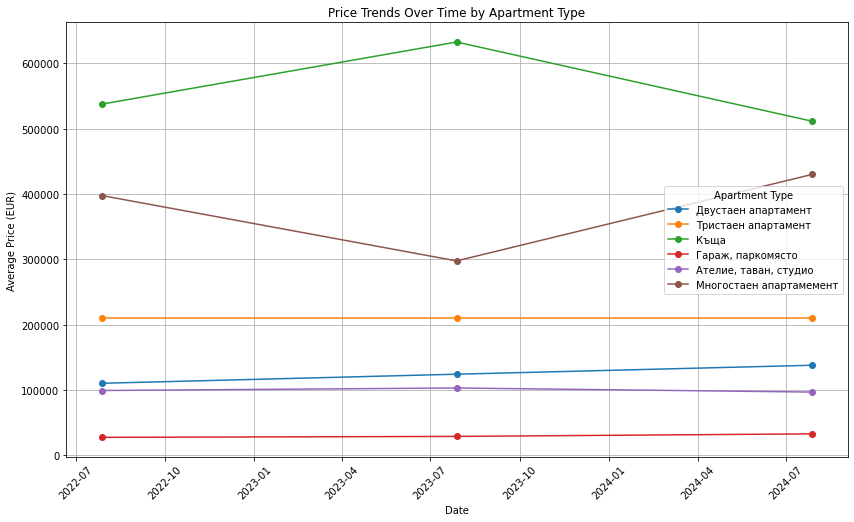

In [17]:
apartment_types = combined_df["Тип Апартамент"].unique()

plt.figure(figsize=(14, 8))

for apartment_type in apartment_types:
    # Filter the DataFrame by apartment type
    filtered_df = combined_df[combined_df["Тип Апартамент"] == apartment_type]
    
    # Group by date and calculate the mean price for each date
    price_over_time = filtered_df.groupby('Дата')['Цена'].median()
    
    # Plot the line for this apartment type
    plt.plot(price_over_time.index, price_over_time.values, marker='o', label=apartment_type)

plt.title('Price Trends Over Time by Apartment Type')
plt.xlabel('Date')
plt.ylabel('Average Price (EUR)')
plt.xticks(rotation=45)
plt.legend(title='Apartment Type')
plt.grid(True)
plt.show()

Let's see how many unique Ragions we have:

In [18]:
len(combined_df['Район'].unique())

100

And which they are:

In [19]:
combined_df['Район'].unique()

array(['Банишора', 'Белите Брези', 'Борово', 'Бояна', 'Бъкстон', 'Витоша',
       'Гевгелийски', 'Гео Милев', 'Горна Баня', 'Гоце Делчев',
       'Дианабад', 'Драгалевци', 'Дружба 1', 'Дружба 2', 'Дървеница',
       'Западен Парк', 'Захарна Фабрика', 'Зона Б18', 'Зона Б19',
       'Зона Б5', 'Иван Вазов', 'Изгрев', 'Изток', 'Илинден', 'Княжево',
       'Красна Поляна', 'Красно Село', 'Кръстова Вада', 'Лагера',
       'Левски', 'Левски В', 'Левски Г', 'Лозенец', 'Люлин 1', 'Люлин 10',
       'Люлин 2', 'Люлин 3', 'Люлин 4', 'Люлин 5', 'Люлин 6', 'Люлин 7',
       'Люлин 8', 'Люлин 9', 'Люлин Център', 'м-т Гърдова глава',
       'Малинова Долина', 'Манастирски ливади Запад',
       'Манастирски ливади Изток', 'Младост 1', 'Младост 1а', 'Младост 2',
       'Младост 3', 'Младост 4', 'Мотописта', 'Мусагеница', 'Надежда 1',
       'Надежда 2', 'Надежда 3', 'Надежда 4', 'Обеля', 'Обеля 1',
       'Обеля 2', 'Оборище', 'Овча Купел', 'Овча Купел 1', 'Овча Купел 2',
       'Павлово', 'Подуене', 

# Let's prepear the model and train it:

Extract date features:

In [20]:
combined_df['Year'] = combined_df['Дата'].dt.year
combined_df['Month'] = combined_df['Дата'].dt.month

Drop the original 'Дата' column and unnecessary columns:

In [21]:
combined_df = combined_df.drop(columns=['Дата', 'Валута'])

In [22]:
combined_df

,Район,Цена,Цена / кв.м.,Тип Апартамент,Year,Month
0,Банишора,110201.52,1710.14,Двустаен апартамент,2022,7
1,Белите Брези,148125.00,1949.01,Двустаен апартамент,2022,7
2,Борово,141912.50,2120.07,Двустаен апартамент,2022,7
3,Бояна,167608.23,1888.09,Двустаен апартамент,2022,7
4,Бъкстон,109764.43,1869.47,Двустаен апартамент,2022,7
...,...,...,...,...,...,...
949,Суха Река,303037.00,1864.02,Многостаен апартамемент,2024,7
950,Хаджи Димитър,331999.50,2049.38,Многостаен апартамемент,2024,7
951,Хиподрума,446333.00,1410.21,Многостаен апартамемент,2024,7
952,Хладилника,817960.00,2493.78,Многостаен апартамемент,2024,7


Encode categorical variables:

In [23]:
label_encoder_region = LabelEncoder()
label_encoder_apartment_type = LabelEncoder()

combined_df['Район'] = label_encoder_region.fit_transform(combined_df['Район'])
combined_df['Тип Апартамент'] = label_encoder_apartment_type.fit_transform(combined_df['Тип Апартамент'])

Define features and target:

In [24]:
X = combined_df.drop(columns=['Цена / кв.м.'], axis=1) 
y = combined_df['Цена / кв.м.']  # Target variable

In [25]:
X

,Район,Цена,Тип Апартамент,Year,Month
0,1,110201.52,2,2022,7
1,3,148125.00,2,2022,7
2,5,141912.50,2,2022,7
3,6,167608.23,2,2022,7
4,7,109764.43,2,2022,7
...,...,...,...,...,...
949,86,303037.00,4,2024,7
950,92,331999.50,4,2024,7
951,93,446333.00,4,2024,7
952,94,817960.00,4,2024,7


Split the data into training and testing sets:

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [27]:
X_train

,Район,Цена,Тип Апартамент,Year,Month
292,3,162233.00,2,2023,7
891,55,32900.00,0,2024,7
736,27,315092.78,5,2024,7
109,25,421500.00,5,2022,7
77,84,173050.00,2,2022,7
...,...,...,...,...,...
106,22,214656.36,5,2022,7
270,37,190996.67,4,2022,7
860,38,44000.00,1,2024,7
435,55,215677.05,5,2023,7


In [28]:
y_train

292    2015.32
891    2056.25
736    3185.05
109    3032.37
77     2273.24
        ...   
106    2161.82
270    1757.64
860    2095.24
435    2239.21
102    1839.47
Name: Цена / кв.м., Length: 763, dtype: float64

In [29]:
X_train.shape, y_test.shape

((763, 5), (191,))

In [30]:
X_test.shape, y_train.shape

((191, 5), (763,))

## Train the model

In [31]:
model = LinearRegression()

In [32]:
model.fit(X_train, y_train)

LinearRegression()

## Prediction results

In [33]:
y_pred = model.predict(X_test)

In [34]:
y_pred

array([1750.68769183, 1839.39383931, 1804.70040078, 1944.07792623,
       1922.38083838, 2219.76097443, 2094.98754327, 1537.72001041,
       2300.23395829, 1872.9110702 , 1428.80262176, 1539.77991914,
       1547.53523397, 2183.63678977, 1807.60635224, 1585.7867115 ,
       1662.43326291, 1670.19373346, 1807.75261896, 1914.9282857 ,
       1956.9735337 , 1828.94517048, 1760.22967186, 1686.11261913,
       1534.811921  , 1777.82094491, 1528.81671619, 2021.42489425,
       1767.09400383, 1537.75367292, 1907.69718555, 1765.20986189,
       1736.7505311 , 1754.21497581, 1579.60087932, 1985.17116354,
       1661.65627825, 1784.10376819, 2044.07519549, 2148.75928242,
       1527.54371103, 1651.77444794, 1534.20011755, 1819.90973642,
       1633.22389514, 1715.39755576, 1421.45287664, 1880.2953017 ,
       1578.62717821, 1780.1590112 , 1641.19677333, 1772.91549362,
       1647.08029418, 1665.05496756, 1979.41164758, 1938.31235138,
       1632.79292199, 1673.4582839 , 1934.39529835, 1957.31744

In [35]:
# Creating a future dataset for prediction
# Example: Predicting for 2025 with specific assumptions for features
future_data = {
    'Район': label_encoder_region.transform(['Банишора', 'Белите Брези']),  # Encode regions
    'Цена': 200000,
    'Тип Апартамент': label_encoder_apartment_type.transform(['Двустаен апартамент', 'Тристаен апартамент']),  # Encode apartment types
    'Year': [2025] * 2,  # Assuming 2 predictions for example purposes
    'Month': [1, 1],  # Predicting for January 2025
}

# Convert to DataFrame
future_X = pd.DataFrame(future_data)

# Make predictions
future_predictions = model.predict(future_X)

# Display predictions
for i, prediction in enumerate(future_predictions):
    print(f"Prediction for {future_data['Район'][i]} - {future_data['Тип Апартамент'][i]}: {prediction:.2f} per square meter")

Prediction for 1 - 2: 1924.90 per square meter
Prediction for 3 - 5: 2064.56 per square meter


In [36]:
# Decode the encoded labels back to their original strings
decoded_regions = label_encoder_region.inverse_transform(future_data['Район'])
decoded_apartment_types = label_encoder_apartment_type.inverse_transform(future_data['Тип Апартамент'])

# Example predictions
future_predictions = [1924.50, 2063.76]

# Display predictions with original labels
for i, prediction in enumerate(future_predictions):
    region_label = decoded_regions[i]
    apartment_type_label = decoded_apartment_types[i]
    print(f"Prediction for {region_label} - {apartment_type_label}: {prediction:.2f} per square meter")

Prediction for Банишора - Двустаен апартамент: 1924.50 per square meter
Prediction for Белите Брези - Тристаен апартамент: 2063.76 per square meter


## Evaluate the model

In [37]:
mse = mean_squared_error(y_test, y_pred)

In [38]:
print("Coefficients:", *model.coef_)
print("Intercept:", model.intercept_)
print("Mean squared error (MSE): %.2f" % mse)
print("Coefficient of determination (R^2): %.2f" % r2_score(y_test, y_pred))

Coefficients: 0.4009262838532397 0.0008129080303898111 46.287871546848585 104.68408692896679 0.0
Intercept: -210315.935911446
Mean squared error (MSE): 361313.15
Coefficient of determination (R^2): 0.33


In [39]:
cdf = pd.DataFrame(model.coef_, X.columns, columns=['Coef'])
cdf

,Coef
Район,0.400926
Цена,0.000813
Тип Апартамент,46.287872
Year,104.684087
Month,0.000000


In [41]:
print("Mean Absolute Error: ", mean_absolute_error(y_test, y_pred))

Mean Absolute Error:  396.1441833754325


## Residuals

In [42]:
residuals = y_test - y_pred

In [43]:
residuals

199   -738.857692
422     98.356161
695    344.759599
751     -6.327926
388    282.459162
          ...    
33    -235.144877
31     452.759690
712     56.328897
321    228.384179
462   -331.966188
Name: Цена / кв.м., Length: 191, dtype: float64